# Introduction

Collaborative filtering is a common recommender system technique, which entails basing recommendations to a user based on choices made by previous users with similar preferences. In the typical e-commerce or media streaming scenario, this can be done rather straight forwardly by encoding purchace or streaming history as a vector whose *n:th* element gives the number of purchaces/streams of item *n*. 

This notebook implements a variation of collaborative filtering adapted to deal with a different scenario. In a product that scans for errors/risks and returns reports detailing any found errors/risks, historic user priorities regarding mitigation might be possible to infer by comparing changes in consecutive reports. Recommendations can then be produced for a novel report by finding previous similar reports delivered to other users and calculating the average change of these "nearest neighbors". Let user *u* recieve a novel report, whose vector representation is *r_u* (where the *m:th* element corresponds to the number of times error *m* was found). The algorithm then finds the nearest neighbors *{r_n}* to *r_u*. For each neighbor, the change between the neighbor report and the next report in that neighbors trajectory is calculated, *{s_n = r_n_1 - r_n}*. A weighted average of these changes is then calculated and used as a basis for a recommendation.

The notebook contains the implemented algorithm as well as functions designed to generate test data to evaluate the algorithm. This test data functions emulates a scenario where the risks/errors are given a designation of their expected negative impach (low, medium, high). It can also emulate a scanner that misses risks/error with some probability. This can be used for extensive parameter study of the algorithm, however in this notebook the algorithm is demonstrated only on 2D test data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load
from tqdm import tqdm

import matplotlib
from scipy import stats
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
import time


from IPython.display import Image, display
from IPython.core.display import HTML

matplotlib.rcParams['figure.dpi'] = 200

In [2]:
blue = '#00BEFF'
pp_blue = '#00b0f0ff'
red = '#FF6B5A'
pp_red= '#ff6b5a'
yellow = '#FFC500'
green = '#34d68a'
pale_gray = '#EFEFF0'
medium_gray = '#B9B9B9'
dark_gray = '#797979'
dark_blue = '#00008B'
black = '#000000'
orange = '#ff8c00'
colors = [yellow, green, pp_blue, red, medium_gray, black, dark_blue, orange, 'blue', 'red', 'teal', 'orange']

# Recommender function

In [3]:
def recommender(k_nn_model, target, trajectory_matrix, user_column, neigh_traj_report_map, n_neighbors, 
                radius=None, weighted_rec=True, test_mode=False, target_scan_idx=None, mode='standard'):
    """
    Given a target report, a trained k-NN model, a data set (matrix with error reports as rows), and a vector
    user map that maps rows of the data matrix to specific users (indexed with 0-start index),
    this function returns a recommendation for which error to prioritize. 
    
    Can be run in four different modes,

        standard: The recommendation is based on neighbor points where the next point in the neighbor trajectory
        is closer to the origin. The recommendation vector is a mean of normalized vectors pointing from neighbor
        to next point in trajectory.
        
        end_point_based: Similar to standard except that the last point rather than the next point in the neighbor
        trajectories is used both for neighbor qualification and for the recommendation vector.
        
        look_ahead: Uses all neighbors regardless of change in trajectory. Recommendation vector is a mean of
        the mean of the up to five next points in the respective neighbor trajectories.
        
        per_dimension: Same qualification criteria as end point based, but same recommendation base as standard.



    Arguments:

        k_nn_model (object): a nearest neighbors sci-kit learn object that has been fit to a data set

        target (np.array): a report in vector representation

        trajectory_matrix (np.array): the full data set on which the neighbor set that the k_nn_model has been fitted to
        is based, on which to also base recommendations

        user_column (np.array): a vector with same length as amount of rows in data matrix, were rows are
        assigned to users with an ad hoc 0-based index.

        neigh_traj_report_map (np.array): a vector that maps neighbor data matrix indices to trajectory data
        matrix indices, neigh_traj_report_map[neighbor_neigh_idx] = neighbor_traj_idx

        n_neighbors (int): the amount of neighbors to use for recommendation

        radius (float): radius in which to look for neighbors. If specified, algorithm finds all neighbors in given radius instead of fixed number at
        arbitrary distance

        weighted_rec (boolean): if true, recommendation is based on proximity-weighted mean. If false, no weights
        are used.

        test_mode (boolean): if run in test mode, target is assumed to be drawn from train set

        target_scan_idx (int): the user trajectory index of the target

        mode (string): specifies which mode to run the algorithm in. Accepts 'standard', 'end_point_based', 'look_ahead'
        and 'per_dimension'. If other argument is supplied, it defaults to 'standard'.

    Return:

        rec (np.array): index in data matrix columns of error type in recommended priority order

        rec_vec (np.array): the recommendation vector from which rec was calculated

        neighbors (np.ndarray): a matrix with neighbors as rows

        neighbor_scan_idx (np.array): user trajectory indexes of neighbors

        neighbor_steps (np.ndarray): vectors pointing from neighbors to next report in respective user trajectory


    """

    modes = ['standard', 'end_point_based', 'look_ahead', 'per_dimension']

    if mode not in modes:
        mode = 'standard'

    # find neigbor distances and idx
    if n_neighbors != None:
        distances, neighbor_neigh_idx = k_nn_model.kneighbors(X=target, n_neighbors=n_neighbors, return_distance=True)
   
    # if n_neighbors == None, use radius based search
    else: 
        distances, neighbor_neigh_idx = k_nn_model.radius_neighbors(X=target, radius=radius, return_distance=True,
                                                                    sort_results=True)

    # extract vectors from one row matrices of k_nn return
    neighbor_neigh_idx = neighbor_neigh_idx[0]
    distances = distances[0]

    # remap indices to trajectory matrix indexing
    neighbor_idx = neigh_traj_report_map[neighbor_neigh_idx]

    # if test mode, remove any "neighbor" that stems from the targets own trajectory
    if test_mode:
        
        # find local indeces of points in same or other trajectories as target
        same_idx_local = np.where(user_column[neighbor_idx] == target_scan_idx)[0]
        other_idx_local = np.where(user_column[neighbor_idx] != target_scan_idx)[0]
        
        # keep only those belonging to other trajectories
        neighbor_idx = neighbor_idx[other_idx_local]
        distances = distances[other_idx_local]

        if len(np.where(user_column[neighbor_idx] == target_scan_idx)[0]) > 0:
            raise Exception('Target kept as its own neighbor! Error in recommender function')

    # find neighbor report vectors
    neighbors = trajectory_matrix[neighbor_idx]

    # list to store the vectors from neighbors to next report in their respective trajectories
    neighbor_steps = []

    # define origin to later use as reference point
    origin = np.zeros(trajectory_matrix.shape[1])

    # iterate over neighbors
    for ndx, neighbor in enumerate(neighbors):
        step_vector = np.zeros(trajectory_matrix.shape[1])
        global_index = neighbor_idx[ndx]
        neighbor_user = user_column[global_index]

        if mode == 'look_ahead':
            look_ahead = 5
        else:
            look_ahead = 1

        # loop across look_ahead many points forward in neighbor trajectory
        for ldx in range(1, look_ahead + 1):

            # check if not end of data matrix
            if global_index + ldx < trajectory_matrix.shape[0]:

                # check if neighbor not last point in own trajectory
                if user_column[global_index] == user_column[global_index + ldx]:

                    # if end point or per dimension modes, prepare to check
                    # last point in trajectory
                    if (mode == 'end_point_based') or (mode == 'per_dimension'):
                        ref_idx = np.where(user_column == neighbor_user)[0][-1]

                    # else if standard, prepare to check next point in trajectory
                    # if look ahead, no check is performed, but ref_idx is
                    # still used when calculating step vec
                    else:
                        ref_idx = global_index + ldx
                        
                    ref_reports = trajectory_matrix[ref_idx]
                    neighbor_reports = trajectory_matrix[global_index]

                    # if not using look ahead, check if ref point in
                    # trajectory is closer to origin
                    if (np.sum(ref_reports) < np.sum(neighbor_reports)) or (mode == 'look_ahead'):

                        # if end point based, add all negative elements of step
                        # vector to last point to step vector
                        if mode == 'end_point_based':
                            step_vector = ref_reports - neighbor_reports
                            step_vector *= (step_vector < 0)

                        # if look ahead, add all elements of step vector to
                        # ref_idx point to step vector
                        elif mode == 'look_ahead':
                            step_vector += ref_reports - neighbor_reports

                        # if per dimension or standard, add only the negative elements of step vector
                        # to next point to step vector
                        else:
                            step_vector = trajectory_matrix[global_index + 1] - trajectory_matrix[global_index]
                            step_vector *= (step_vector < 0)

        # normalize if not zero-length
        if np.linalg.norm(step_vector) > 0:
            step_vector /= np.linalg.norm(step_vector)

        # append step vector. If neighbor had increase in errors, step
        # vector will only be zeros
        neighbor_steps.append(step_vector)

    # recommendation vector
    rec_vec = np.zeros(trajectory_matrix.shape[1])

    # iterate over neighbor steps, sum and weight by distance
    for vdx, vector in enumerate(neighbor_steps):
        if weighted_rec:
            rec_vec += (1 / (len(np.where(distances==distances[vdx])[0])*distances[vdx] + 1)) * vector
        else:
            rec_vec += vector
                
    # do not recommend non existent error
    zero_dims = np.where(target[0] == 0)[0]

    rec_vec[zero_dims] = 0
    
    # remove any positive elements
    rec_vec *= (rec_vec < 0)

    # normalize recommendation vector
    if np.linalg.norm(rec_vec) != 0:
        rec_vec = rec_vec / np.linalg.norm(rec_vec)

    # check if rec vec is only zeros (means no decreasing neighbor was found)
    if (distance.cityblock(rec_vec, origin) == 0) or (np.sum(rec_vec) == 0):
        rec_vec.fill(np.nan)
        rec = np.copy(rec_vec)

    # if there was basis for recommendation among neighbors, return recommendation sorted by strength
    else:
        rec = np.argsort(rec_vec)  # sorts in rising order

    return rec, rec_vec, neighbors, neighbor_idx, neighbor_steps, distances


# Data transform functions

In [4]:
def duplicate_singles_remover(data_matrices, user_columns, user_map, only_reformat = False):
    '''
    Discards reports identical to previous report in user trajectory, then discards user trajectories that only
    have one report.
    
    Parameters:
    
        data_matrices (list of numpy ndarrays): a collection of data matrices, one per user trajectory
        user_columns (list of numpy arrays): a collection of arrays, one per user trajectory of
        same length as number of rows in same user trajectorys' data matrix, filled with a user specific
        0-based index.
        user_map (list): maps from 0-based index to user marker, user_map[index] = user marker
        only_reformat (boolean): in testing scenarios, it might be unsuitable to remove duplicate singles. To keep the data
        processing chain intact in these cases, this boolean allows using this function without removing anything.
        
    Return:
        
        data_matrices_pruned (list of numpy ndarrays)
        user_columns_pruned (list of numpy arrays)
        user_map_pruned (list)
    
    '''
    
    data_matrices_pruned = []
    user_columns_pruned = []
    user_map_pruned = []
    deleted_reports = 0
    users_w_deleted_reports = 0
    deleted_users = 0
 
    n_reports = 0
    
    # iterate over user trajectorys
    for idx, data_matrix in enumerate(data_matrices):
        
        n_reports += len(data_matrix)
        
        # list to store which reports to delete
        delete_idx = []
        
        # iterate over reports in user trajectories
        for rpd, report in enumerate(data_matrix):
            # ignore first
            if rpd > 0:
                # check if report is identical to previous, in that case add its index to delete
                if np.all( report == data_matrix[rpd - 1] ):
                    delete_idx.append(rpd)
        
        if only_reformat:
            delete_idx = []
            
        # delete duplicate reports and their user trajectory mappings
        data_matrix = np.delete(data_matrix, delete_idx, axis = 0)
        user_column = np.delete(user_columns[idx], delete_idx, axis = 0)

        # keep track of deleted reports
        if len(delete_idx) > 0:
            deleted_reports += len(delete_idx)
            users_w_deleted_reports += 1

        # only accept user trajectorys with more than one report
        if data_matrix.shape[0] > 1:
            data_matrices_pruned.append(data_matrix)
            user_columns_pruned.append(user_column)
            user_map_pruned.append(user_map[idx])

        # keep track of deleted user trajectories
        else:
            deleted_users += 1
            deleted_reports += 1

    #re-adjust indexing of user trajectories after deleting user trajectories with only one report
    for i in range(len(user_columns_pruned)):
        user_columns_pruned[i].fill(i)
    
    #print some stuff
    print("deleted " + str(deleted_reports) + " reports across " + str(users_w_deleted_reports) + " user trajectories")
    print("deleted " + str(deleted_users) + " users entirely")
    n_total_reports = n_reports - deleted_reports
    print(str(n_reports - deleted_reports) + " reports remaining")
    
    return data_matrices_pruned, user_columns_pruned, user_map_pruned

In [5]:
def too_few_error_types_remover(data_matrices, limit = 3):
    '''
    Discards any points with less than limit different error types. The resulting data set is returned
    along with a mapping between indices of reports in the unformatted and formatted data sets. The formatted
    data set (neighbor_matrix) is to be used when searching for neighbors, as reports with less than limit error types are
    considered to contain to little information to be usefull to the recommendation engine.
    
    '''
    
    # at [neighbor_matrix report index], this list will contain [trajectory_matrix index]
    neigh_traj_report_map = []
    
    report_idx = 0 # to store original index
    
    reports_pruned = []
    reports_deleted = 0
   
    # iterate over user trajectorys
    for ddx, data_matrix in enumerate(data_matrices):
        
        # new pruned user trajectory
        data_matrix_pruned = []
        
        # go through reports in user trajectory, add report to pruned only if more than limit error types      
        for rdx, report in enumerate(data_matrix):
            
            n_types_in_report = len( np.where( report != 0 )[0] )

            if n_types_in_report >= limit:
                reports_pruned.append(report)
                neigh_traj_report_map.append(report_idx)
 
            else:
                reports_deleted += 1

            report_idx += 1
            
    neighbor_data_matrix = np.zeros(( len(reports_pruned), len(reports_pruned[0]) ))
    
    # build a matrix containing all pruned users
    for i in range( len(reports_pruned) ):
        neighbor_data_matrix[i] = reports_pruned[i]
    
    return neighbor_data_matrix, neigh_traj_report_map
    
    

In [6]:
def create_trajectory_and_neighbor_matrices(data_matrices, user_columns, limit = 3):
    '''
    Concatenates a collection of data matrices and user trajectory columns to one large matrix and one long column.
    Also utilizes too_few_error_types_remover() to create neighbor data matrix.
    
    Parameters:
        data_matrices (list of ndarrays): data matrices extracted from a data frame with create_data_matrix()
        user_columns (list of arrays): user trajectory columns extracted from a data frame with create_data_matrix()
    
    Returns:
        trajectory_matrix (ndarray)
        trajectory_user_column (array)
        neighbor_data_matrix (ndarray)
        neigh_traj_report_map (array): at index [neighbor index], this array contains [original index]
    '''
    
    # retrieve neighbor data matrix and neighbor to full matrix row index mapping
    neighbor_data_matrix, neigh_traj_report_map = too_few_error_types_remover(data_matrices, limit = limit)

    # initialize trajectory matrix & column
    n_error_threat_combos = data_matrices[0].shape[1]
    n_total_reports = 0

    for data_matrix in data_matrices:
        n_total_reports += data_matrix.shape[0]

    trajectory_matrix = np.zeros((n_total_reports, n_error_threat_combos))
    trajectory_user_column = np.zeros((n_total_reports)).astype(int)

    # loop over matrices and columns in collection, add to trajectory matrix & column
    current_row = 0
    for idx, data_matrix in enumerate(data_matrices):
        user_column = user_columns[idx]
        n_rows = len(user_column)

        trajectory_matrix[current_row:(current_row + n_rows)] = data_matrix
        trajectory_user_column[current_row:(current_row + n_rows)] = user_column

        current_row += n_rows

    
    return trajectory_matrix, trajectory_user_column, neighbor_data_matrix, np.array(neigh_traj_report_map)


# Test data generator functions

In [7]:
class toy_user:
    '''
    Imitates a user trajectory that can decrease errors in a deterministic manner and output reports where errors
    might be missed. Errors are assigned high, medium or low impact and user behaviour is modeled to adapt to this.
    '''
    
    def __init__(self, start_point, max_errs_of_type_per_loc, miss_prob, 
                 high = (0,50), medium = (50,100), low = (100, 150)):
        
        self.miss_prob = miss_prob 
        self.max_errs_of_type_per_loc = max_errs_of_type_per_loc
        self.loc_matrix = self.construct_matrix(start_point)
        self.high = high
        self.medium = medium
        self.low = low

        
    def construct_matrix(self, start_point):
        n_cols = int(start_point.size)
        n_rows = int(np.ceil(np.max(start_point) / self.max_errs_of_type_per_loc))
        
        if n_rows == 1:
            n_rows += 1
        
        matrix = np.zeros((n_rows, n_cols))
        
        
        # loop through start point, distribute errors across loc_matrix
        for error_type, n_errors in enumerate(start_point):
            
            if n_errors > 0:
                prob = 1 / n_errors
                placed = 0

                row = 0

                while placed < n_errors:
                    rand = np.random.rand()

                    if rand < prob:
                        matrix[row,error_type] += 1
                        placed +=1

                    row +=1

                    row %= matrix.shape[0]
        
        return matrix
    
    def get_report(self):
        
        report = np.zeros((self.loc_matrix.shape[1]))
        
        for row in self.loc_matrix:
            
            rand = np.random.rand()
            
            if rand > self.miss_prob:
                
                report += row
        
        return report
    
    def get_true_report(self):
        
        report = np.zeros((self.loc_matrix.shape[1]))
        
        for row in self.loc_matrix:
            
            report += row
        
        return report
    
    def update(self):
        
        # False until error type to mitigate and # errors to mitigate has been determined
        update_ready = False
        
        # False until # errors of determined error type has been mitigated
        updated = False
        
        # Extract # errors per error type in current state
        current_errors = np.sum(self.loc_matrix, axis = 0)
        
        # variable to keep track of performed "actions" (error decreases) this time step by customer
        actions_done = 0
        
        # check if non zero user
        if np.sum(current_errors > 0):
            
            # check above 7s, prioritize max error over 7:
            above_7s = np.where(current_errors > 7)[0]
            
            # if above 7s exist, prioritize error type with max # errors
            if len(above_7s) > 0:
                lead_err = np.argmax(current_errors)
                actions_to_do = 2

            else:
                impact = [self.high,self.medium,self.low]
                sevdx = 0
                
                # iterate over impact
                while not update_ready:
                    impact_errors = current_errors[impact[sevdx][0]:impact[sevdx][1]]
                    
                    # check if there are errors of current impact
                    if np.sum(impact_errors) > 0:
                        
                        # check if there is error typ of current impact with > 2 # errors
                        above_2s = np.where(impact_errors > 2)[0]
                        
                        if len(above_2s) > 0:
                            lead_err = np.argmax(impact_errors) + impact[sevdx][0]
                            actions_to_do = 2
                            update_ready = True
                              
                    sevdx += 1

                    #if no above 7 or above 2 found, set first non zero element as lead find
                    if (not update_ready) and (sevdx == 2):
                        lead_err = np.argmax(current_errors)
                        actions_to_do = 1
                        update_ready = True

            # iterate over reports and remove errors of leading typ until enough # errors has been removed
            row = 0

            while not updated:

                if self.loc_matrix[row, lead_err] > 0:
                    self.loc_matrix[row, lead_err] -= 1
                    actions_done += 1
                    
                if actions_done == actions_to_do:
                    updated = True

                row += 1
                row = row%self.loc_matrix.shape[0]
                
        # Extract # errors per error type in updated state
        current_errors = np.sum(self.loc_matrix, axis = 0)
        
        # If origin reached, return True, otherwise, return False
        if np.sum(current_errors) == 0:
            return True
        else:
            return False
            


In [8]:
def generate_test_data_matrix(start_points, max_errs_of_type_per_loc, density, miss_prob, 
                              high = (0,50), medium = (50,100), low = (100, 150)):
    '''
    Given a matrix with starting points, this function generates a user trajectory per starting point,
    updates each iteratively until they max out of updates or reach the origin. In each such iteration
    this function also extract a noisy report from the user trajectory
    as well as a true report not compromised by noise. These two categories of reports are returned 
    in the format appropriate for the recommendation function.
    '''

    n_dims = start_points.shape[1]

    data_matrices = []
    true_data_matrices = []
    user_columns = []
    user_idx = 0
    user_map = []
    
    done = False
    point_idx = 0
    
    while not done:
        user_map.append(user_idx)
        reports = []
        true_reports = []
        user_list = []
        max_length = np.random.randint(low = 1, high = 20)
        current_point = start_points[point_idx]
        reports.append(current_point)
        true_reports.append(current_point)
        user_list.append(user_idx)
              
        user = toy_user(current_point, max_errs_of_type_per_loc, miss_prob, 
                 high = high, medium = medium, low = low)
        
        user_done = False
        
        if np.sum(current_point) == 0:
            print("zero start!")
            user_done = True
            
        report_counter = 0
        
        while not user_done:
            
            user_done = user.update()
            
            true_reports.append(user.get_true_report())
            reports.append(user.get_report())
            
            if np.sum(user.get_true_report()) == 0:
                user_Done = True

            user_list.append(user_idx)
            
            if report_counter == max_length:
                user_done = True
            
            report_counter += 1
        
        user_idx +=1

        skip_point = True
        
        reports = np.array(reports)
        point_idx += 1
        data_matrices.append(reports)
        true_data_matrices.extend(true_reports)
        user_columns.append(user_list)

        if point_idx == len(start_points):
            done = True
    
    trajectory_truth_matrix = np.zeros((len(true_data_matrices),len(true_data_matrices[0])))
    
    for i in range( len(true_data_matrices) ):
        trajectory_truth_matrix[i] = true_data_matrices[i]
        
    return data_matrices, trajectory_truth_matrix, user_columns, user_map
        
        
    

# Demonstrate algorithm on 2D test data

In [13]:
# Generate 10 user trajectories from points drawn from random distribution, force one start point at [7,0]

start_points = np.absolute(np.round(np.random.normal(loc = 5, scale = 10, size = (11,2))))
start_points[10,0] = 7
start_points[10,1] = 0
max_errs_of_type_per_loc = 4
density = 1
miss_prob = 0
data_matrices, trajectory_truth_matrix, user_columns, user_map = generate_test_data_matrix(start_points, 
                                max_errs_of_type_per_loc, density, miss_prob, 
                                high = (0,2), medium = (2,5), low = (5, 20))

print("shape of generated data matrix")
print(len(data_matrices))
print("number of generated user trajectories")
print(user_columns[-1][0] + 1)
print("user trajectory column")
print(user_columns)


shape of generated data matrix
11
number of generated user trajectories
11
user trajectory column
[[0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 3, 3, 3, 3, 3], [4, 4, 4, 4, 4], [5, 5], [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [8, 8, 8], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [10, 10, 10, 10, 10]]


In [14]:
limit = 2

# process generated matrices
data_matrices_pruned, user_columns_pruned, _ = duplicate_singles_remover(data_matrices, user_columns, user_map)

final_user = user_columns_pruned[-1][0]

# inject designed increasing user to test disregarding of increasing neighbors
data_matrices_pruned.append(np.array([[10,1],[10,2]]))
user_columns_pruned.append(np.array([final_user + 1, final_user + 1]))

trajectory_matrix, trajectory_user_column, neighbor_data_matrix, neigh_traj_report_map = create_trajectory_and_neighbor_matrices(data_matrices_pruned, user_columns_pruned, limit = limit)

print("number of reports in pruned data set")
print(len(trajectory_matrix))
print("number of user trajectorys in pruned data set")
print(trajectory_user_column[-1])


deleted 0 reports across 0 user trajectories
deleted 0 users entirely
81 reports remaining
number of reports in pruned data set
83
number of user trajectorys in pruned data set
11


len neigh matrix / traj report map
60
60


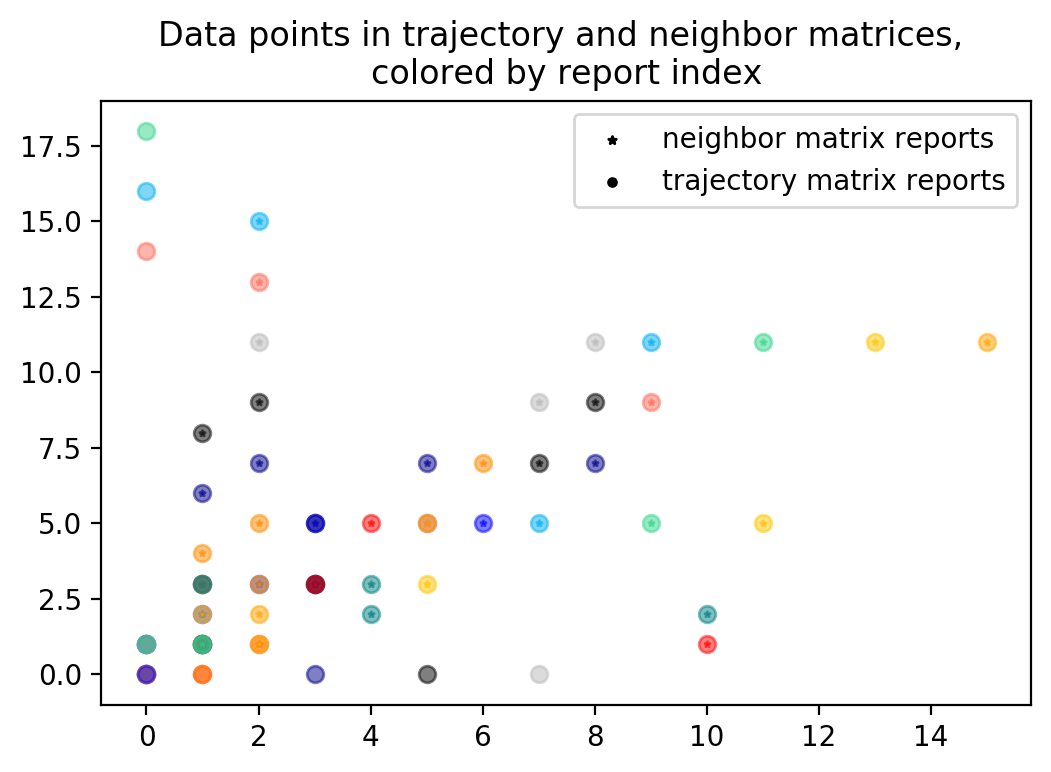

In [15]:
# plot the resulting data set

rdx = 0
for user_idx in range(int(trajectory_user_column[-1]) + 1):
   
    trajectory = trajectory_matrix[ np.where(trajectory_user_column == user_idx)[0]]
    for report in trajectory:
        plt.scatter(report[0],report[1], alpha = 0.5, color = colors[ rdx % len(colors) ])
        rdx += 1

ndx = 0
print("len neigh matrix / traj report map")
print(len(neighbor_data_matrix))
print(len(neigh_traj_report_map))

plt.scatter([],[], marker = '*', s = 8, color = black, label = 'neighbor matrix reports')
plt.scatter([],[], s = 8, color = black, label = 'trajectory matrix reports')

for report in neighbor_data_matrix:

    plt.scatter(report[0],report[1], marker = '*', s = 4, alpha = 0.6, color = colors[ neigh_traj_report_map[ndx] % len(colors) ])
    ndx += 1
plt.legend()
plt.title("Data points in trajectory and neighbor matrices, \ncolored by report index")
plt.show()

Running rec. algorithm in mode standard



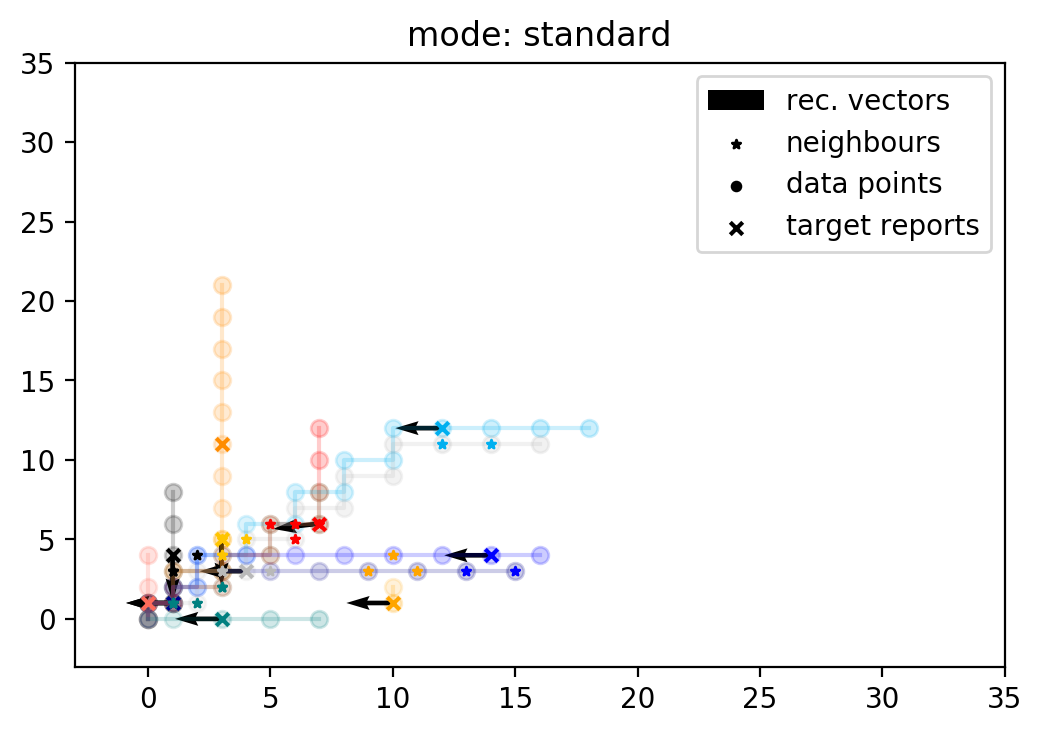

Running rec. algorithm in mode look_ahead



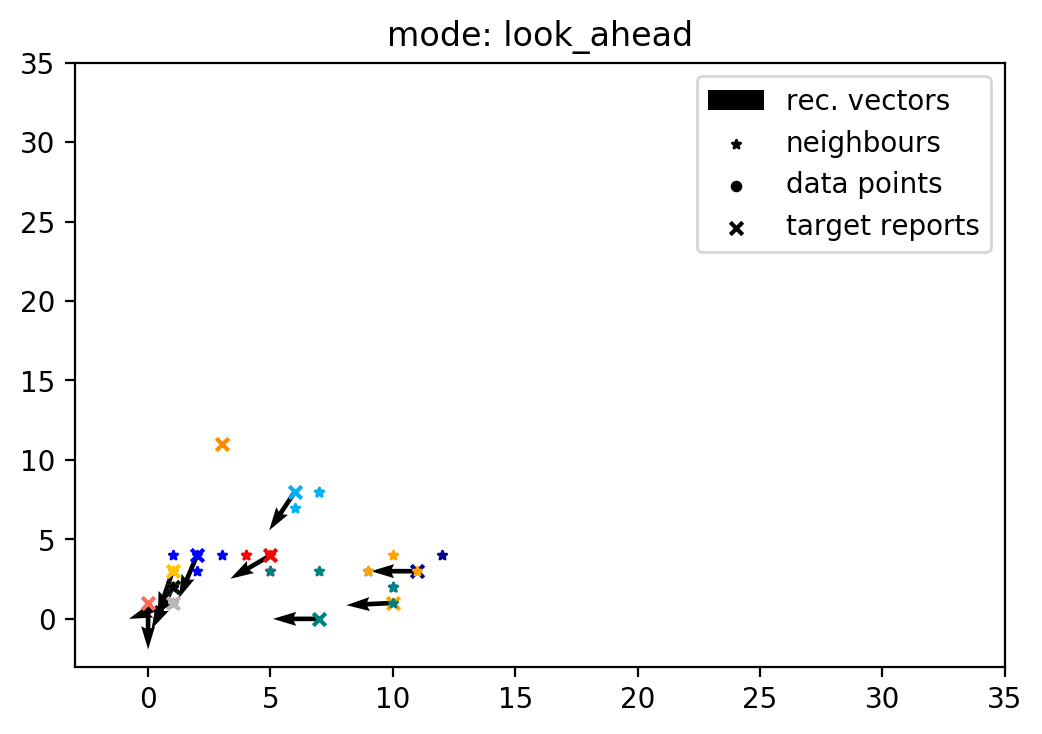

Running rec. algorithm in mode end_point_based



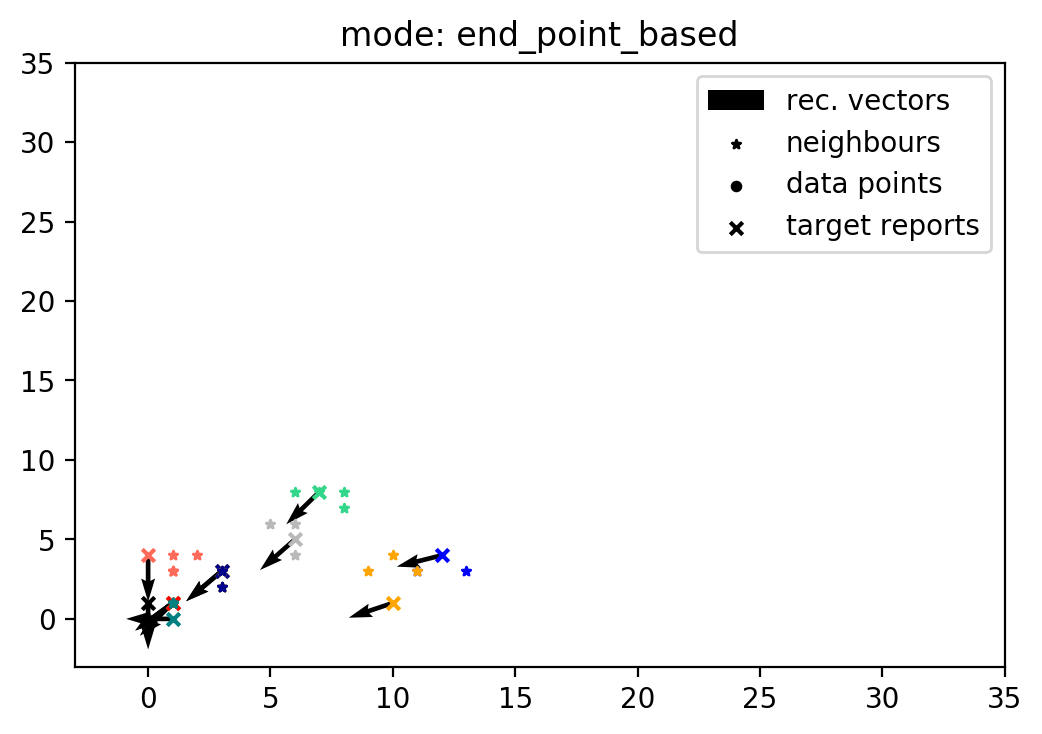

Running rec. algorithm in mode per_dimension



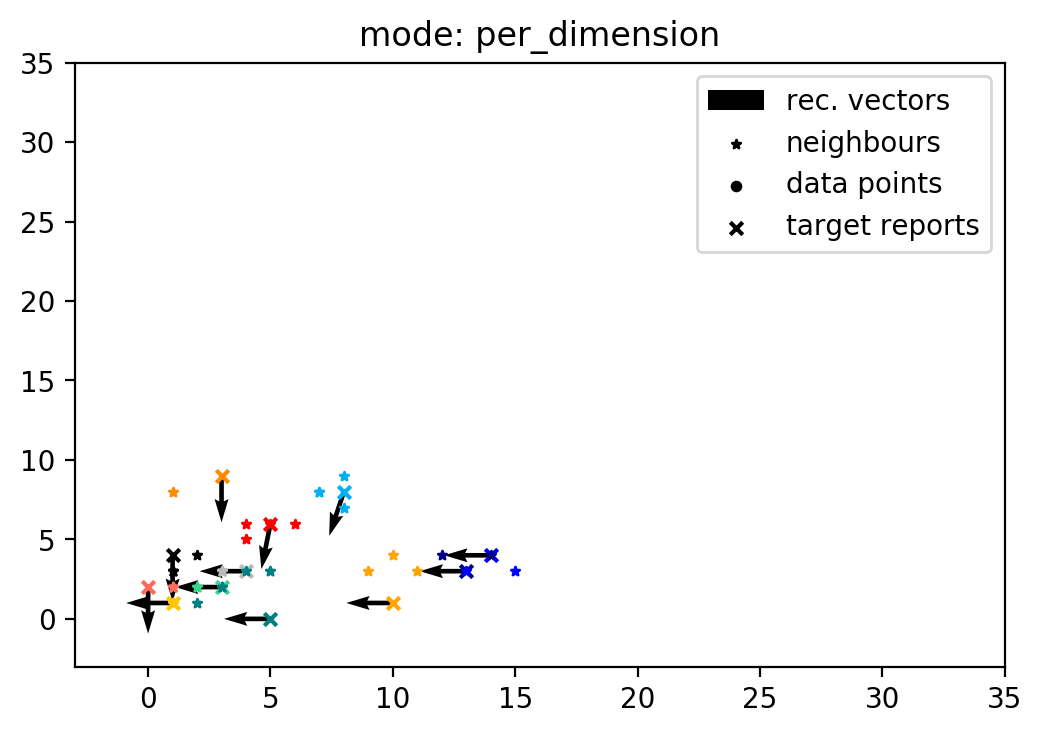

In [12]:
# train k_nn test model
n_neighbors = 5
neigh = NearestNeighbors(n_neighbors = n_neighbors, metric = 'manhattan')
neigh.fit(neighbor_data_matrix)

# plot each user trajectory in individual color
n_users = trajectory_user_column[-1] + 1

for pdx in range(n_users):
    user_idx = np.where(trajectory_user_column == pdx)[0]

    for j in range(len(trajectory_matrix[user_idx,0])):
        plt.scatter(trajectory_matrix[user_idx[0] + j,0],trajectory_matrix[user_idx[0] + j,1], alpha = 0.1*(2 - j/len(trajectory_matrix[user_idx,0])), color = colors[pdx % len(colors)])

    plt.plot(trajectory_matrix[user_idx,0],trajectory_matrix[user_idx,1], alpha = 0.2,color = colors[pdx % len(colors)])

# iterate over user trajectorys in data set and recommendation modes
modes = ['standard','look_ahead','end_point_based','per_dimension']
for mode in modes:
    print("Running rec. algorithm in mode " + mode)
    
    i = 0
    
    # lists to store results
    all_recs = []
    all_rec_vecs = []
    all_targets = []
    all_neighbors = []
    all_neighbor_idx = []
    all_neighbor_steps = []
    all_true_steps = []
    failed_idx = []
    succesfull_idx = []
    all_distances = []
    
    while i < (n_users):

        # extract current trajectory
        user_idx = i
        user_rows = np.where(trajectory_user_column == user_idx)[0]
        trajectory = trajectory_matrix[user_rows]

        # extract random report that is not the last of current user trajectory
        high = user_rows.shape[0] - 1
        target_report_idx = np.random.randint(low = 0, high = high, size = 1)

        # randomly drawn report is now target report for which to make recommendation
        target_report = trajectory[target_report_idx]
        all_targets.append(target_report)

        # make recommendation
        rec, rec_vec, neighbors, neighbor_idx, neighbor_steps, distances = recommender(neigh,
                                                                            target_report,
                                                                            trajectory_matrix, 
                                                                            trajectory_user_column,
                                                                            neigh_traj_report_map,
                                                                            n_neighbors,
                                                                            test_mode = True, 
                                                                            target_scan_idx = user_idx, 
                                                                            mode = mode)

        # plot recommendations vectors
        plt.quiver(target_report[0,0],target_report[0,1],rec_vec[0],rec_vec[1],scale = 20, width = 0.005)
        
        # Mark neighbors with stars in same color as target trajectory
        plt.scatter(neighbors[:,0],neighbors[:,1], color = colors[i % len(colors)], s = 10, marker = '*', zorder = 10)
        
        # Mark target in same color as target trajectory
        plt.scatter(target_report[0,0],target_report[0,1], color = colors[i % len(colors)], s = 20, marker = 'x', zorder = 9)
        
        all_distances.append(distances)

        # check for nan, if not, store results
        if not np.isnan(rec[0]):
            
            # store k-nn recommendation results
            all_recs.append(rec)
            all_rec_vecs.append(rec_vec)
            all_neighbors.append(neighbors)
            all_neighbor_idx.append(neighbor_idx)
            all_neighbor_steps.append(neighbor_steps)

            # extract and store the true step from the target report to next report from target user trajectory
            true_step = trajectory[target_report_idx + 1] - target_report
            all_true_steps.append( true_step )

            succesfull_idx.append(i)

        # nan occurs in rec vec when no neighbors qualified
        else:
            failed_idx.append(i)

        i += 1
    
    #plt.legend()
    plt.title('mode: ' + mode)
    plt.xlim([-3,35])
    plt.ylim([-3,35])
    
    # empty plots only to set labels
    plt.quiver([],[],[],[],scale = 2, label = 'rec. vectors', width = 0.005)
    plt.scatter([],[], color = black, s = 10, marker = '*', zorder = 10, label = 'neighbours')
    plt.scatter([],[], s = 10, label = 'data points', color = black)
    plt.scatter([],[], color = black, s = 20, marker = 'x', zorder = 9, label = 'target reports')
    
    print()
    
    plt.legend()
    plt.show()